In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gvar as gv

from read_data import get_2pt_data, get_ratio_data, get_sum_data, get_fh_data

from lametlat.utils.plot_settings import *
from lametlat.utils.resampling import jk_ls_avg, bs_ls_avg
from lametlat.utils.constants import *
from lametlat.utils.funcs import constant_fit
from lametlat.preprocess.read_raw import pt2_to_meff
from lametlat.gsfit.pt2_fit import pt2_two_state_fit
from lametlat.preprocess.dispersion import disp_relation_plot

a = 0.06
Lt = 64
Ls = 48
m_pi = 0.3 # GeV
N_conf = 553
tsep_ls = [6, 8, 10, 12]

mom_unit = 0.608

### Effective mass of 2pt

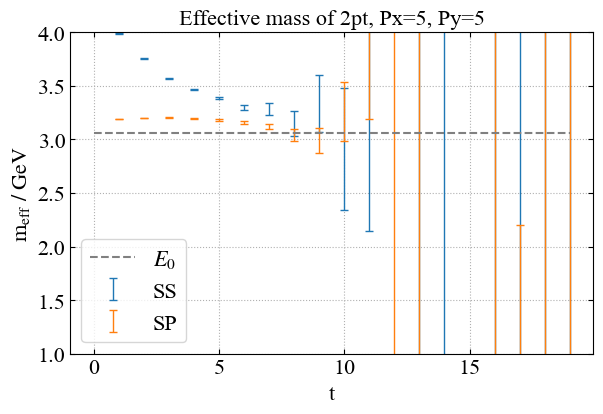

In [3]:
px = py = 5
pz = 0
pnorm = np.sqrt(px**2 + py**2)
p_gev = lat_unit_convert(pnorm, a, Ls, dimension="P")
e_gev = np.sqrt(p_gev**2 + m_pi**2)

pt2_ss_real, pt2_ss_imag = get_2pt_data("SS", px, py, pz, jk_bs="jk")
pt2_sp_real, pt2_sp_imag = get_2pt_data("SP", px, py, pz, jk_bs="jk")
pt2_ss_avg = jk_ls_avg(pt2_ss_real)
pt2_sp_avg = jk_ls_avg(pt2_sp_real)

meff_ss_avg = pt2_to_meff(pt2_ss_avg, boundary="none")
meff_sp_avg = pt2_to_meff(pt2_sp_avg, boundary="none")

meff_ss_avg = meff_ss_avg / a * GEV_FM
meff_sp_avg = meff_sp_avg / a * GEV_FM

fig, ax = default_plot()
ax.errorbar(np.arange(20), gv.mean(meff_ss_avg)[:20], yerr=gv.sdev(meff_ss_avg)[:20], label="SS", **errorb)
ax.errorbar(np.arange(20), gv.mean(meff_sp_avg)[:20], yerr=gv.sdev(meff_sp_avg)[:20], label="SP", **errorb)
ax.plot(np.arange(20), e_gev * np.ones(20), "--", color="gray", label=r"$E_0$")
ax.legend(**fs_p)
ax.set_ylim(1, 4)
ax.set_ylabel(r"m$_{\mathrm{eff}}~/~\mathrm{GeV}$", **fs_p)
ax.set_title(f"Effective mass of 2pt, Px={px}, Py={py}", **fs_p)
ax.set_xlabel("t", **fs_p)
plt.show()

### Dispersion relation

Least Square Fit:
  chi2/dof [dof] = 0.44 [5]    Q = 0.82    logGBF = 5.9935

Parameters:
              m    0.312 (90)     [  0.30 (10) ]  
             c1    1.084 (44)     [  1.00 (10) ]  
             c2   -0.008 (63)     [   0 ± 0.10 ]  

Fit:
     x[k]          y[k]     f(x[k],p)
-------------------------------------
  1.21764    1.304 (33)    1.305 (21)  
  1.82646    1.917 (47)    1.925 (22)  
  2.43528    2.591 (45)    2.549 (28)  
   3.0441    3.141 (85)    3.174 (48)  
  3.65292     3.67 (19)    3.798 (91)  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 5/0.0)
  fitter = scipy_least_squares    method = trf



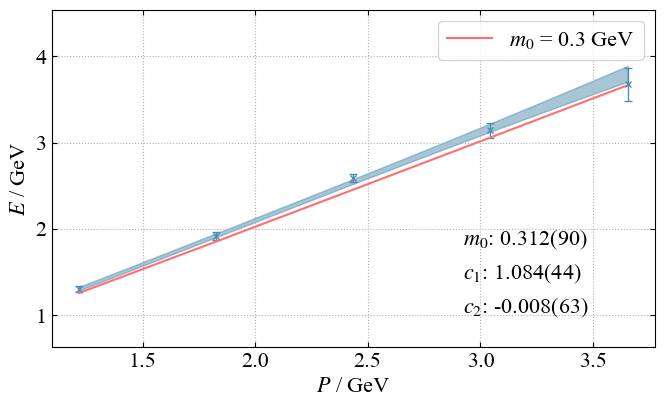

In [3]:
p_array = np.arange(2, 7)
pnorm_array = p_array * np.sqrt(2)

tmin = 3
tmax = 13

e0_ls = []
for px in p_array:
    py = px
    pz = 0

    pt2_ss_real, pt2_ss_imag = get_2pt_data("SS", px, py, pz, jk_bs="jk")
    pt2_ss_avg = jk_ls_avg(pt2_ss_real)
    
    ss_fit_res = pt2_two_state_fit(pt2_ss_avg, tmin, tmax, Lt, normalize=True, label="2pt SS")
    
    e0_ls.append(ss_fit_res.p["E0"])

priors = gv.BufferDict()
priors["m"] = gv.gvar(0.3, 0.1)
priors["c1"] = gv.gvar(1, 0.1)
priors["c2"] = gv.gvar(0, 0.1)

fig, ax = disp_relation_plot(a, Ls, pnorm_array, e0_ls, m0=0.3, input_priors=priors)
fig.tight_layout()
fig.savefig("../output/plots/disp_relation.pdf", transparent=True)
plt.show()


### Effective mass of tmdwf

[1.2176397188827717, 1.8264595783241575, 2.4352794377655433, 3.0440992972069294, 3.652919156648315]
[1.2540520264330803, 1.8509334378232134, 2.453688232030235, 3.0588462745381175, 3.665217369407746]


/home/jinchen/git/package/LaMETLat/lametlat/preprocess/read_raw.py:76: RuntimeWarning: invalid value encountered in log
  meff_array = np.log(pt2_array[:-1] / pt2_array[1:])


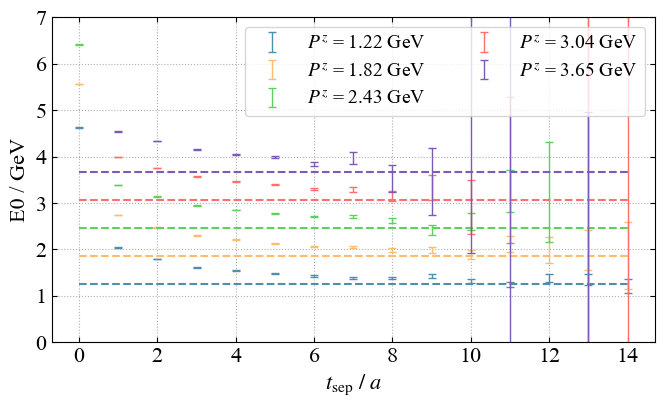

In [9]:
gamma = 14
px_ls = np.arange(2, 7)
p_gev_ls = [lat_unit_convert(px, a, Ls, dimension="P") * np.sqrt(2) for px in px_ls]
e_gev_ls = [np.sqrt(p**2 + m_pi**2) for p in p_gev_ls]

pz = 0
b = 0
z = 0

tmax = 15

fig, ax = default_plot()
for idx, px in enumerate(px_ls):
    py = px
    pt2_ss_real, pt2_ss_imag = get_2pt_data("SS", px, py, pz, jk_bs="jk")
    pt2_ss_avg = jk_ls_avg(pt2_ss_real)
    
    meff_avg = pt2_to_meff(pt2_ss_avg, boundary="none")
    
    meff_avg = meff_avg / a * GEV_FM
    
    pz_mom = round(mom_unit * px, 2)
    
    ax.errorbar(np.arange(tmax), gv.mean(meff_avg)[:tmax], 
                yerr=gv.sdev(meff_avg)[:tmax], 
                label=r"$P^z$ = " + str(pz_mom) + " GeV", color=color_ls[idx], **errorb)
    
    ax.plot(np.arange(tmax), e_gev_ls[idx] * np.ones(tmax), "--", color=color_ls[idx])

ax.legend(loc="upper right", ncol=2, **fs_small_p)
# ax.set_title(f"Effective mass of 2pt SS", **fs_p)
ax.set_xlabel(r"$t_{\rm sep}~/~a$", **fs_p)
ax.set_ylabel("E0 / GeV", **fs_p)
ax.set_ylim(0, 7)
plt.tight_layout()
plt.savefig("../output/plots/effective_mass_2pt_ss.pdf", transparent=True)
plt.show()

### Ratio data plot

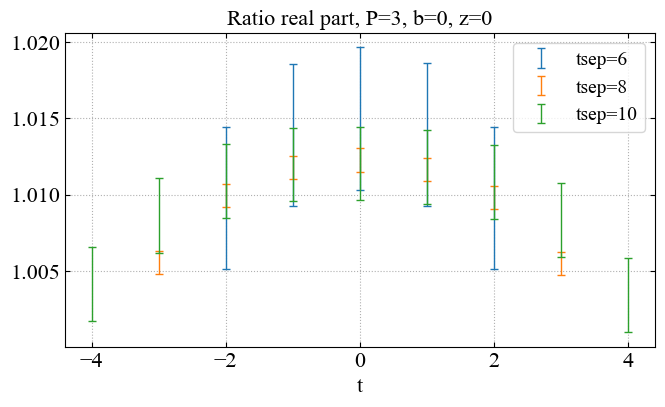

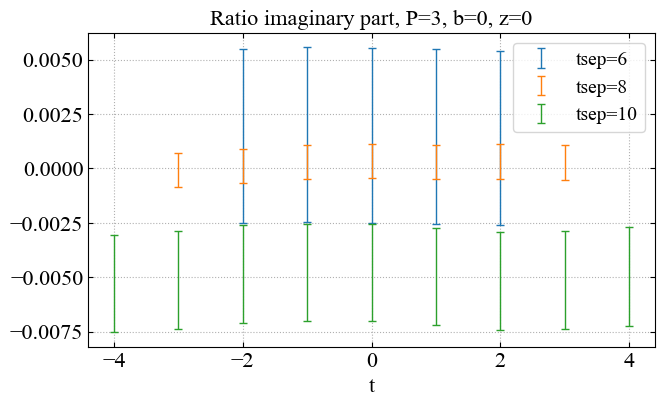

In [5]:
px = py = 3
pz = 0
b = 0
z = 0
tau_cut_plot = 1
tsep_ls_plot = [6, 8, 10]
        
        
# * ratio
ra_real, ra_imag = get_ratio_data(px, py, pz, b, z, tsep_ls, jk_bs="jk")
ra_real_avg = jk_ls_avg(ra_real)
ra_imag_avg = jk_ls_avg(ra_imag)


# * plot real part
fig, ax = default_plot()

for id, tsep in enumerate(tsep_ls_plot):
    x_ls = np.arange(tau_cut_plot, tsep + 1 - tau_cut_plot) - tsep / 2  
    y_ls = gv.mean(ra_real_avg)[id, tau_cut_plot : tsep + 1 - tau_cut_plot]
    yerr_ls = gv.sdev(ra_real_avg)[id, tau_cut_plot : tsep + 1 - tau_cut_plot]
    ax.errorbar(x_ls, y_ls, yerr_ls, label=f"tsep={tsep}", **errorb)
ax.set_title(f"Ratio real part, P={px}, b={b}, z={z}", **fs_p)
ax.set_xlabel("t", **fs_p)
ax.legend(loc="upper right", **fs_small_p)
plt.tight_layout()
plt.show()


# * plot imag part
fig, ax = default_plot()

for id, tsep in enumerate(tsep_ls_plot):
    x_ls = np.arange(tau_cut_plot, tsep + 1 - tau_cut_plot) - tsep / 2  
    y_ls = gv.mean(ra_imag_avg)[id, tau_cut_plot : tsep + 1 - tau_cut_plot]
    yerr_ls = gv.sdev(ra_imag_avg)[id, tau_cut_plot : tsep + 1 - tau_cut_plot]
    ax.errorbar(x_ls, y_ls, yerr_ls, label=f"tsep={tsep}", **errorb)
ax.set_title(f"Ratio imaginary part, P={px}, b={b}, z={z}", **fs_p)
ax.set_xlabel("t", **fs_p)
ax.legend(loc="upper right", **fs_small_p)
plt.tight_layout()
plt.show()


### Sum data plot

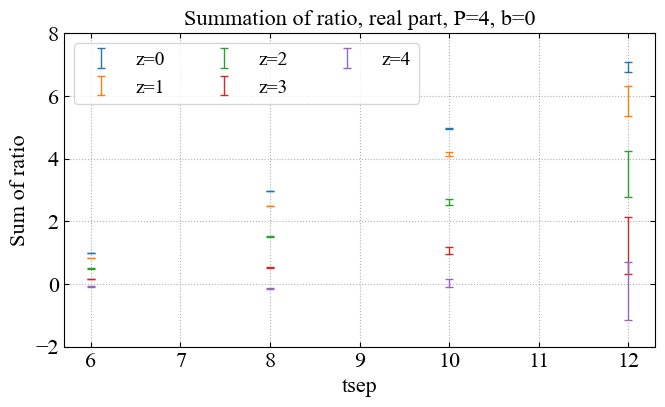

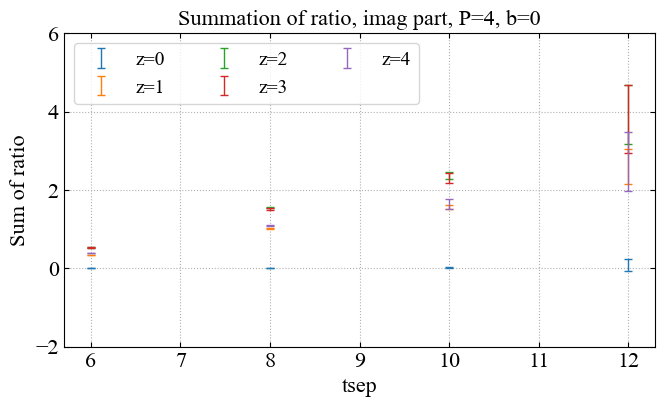

In [6]:
px = py = 4
pz = 0
b = 0
z = 0
tau_cut_plot = 3

# * sum real part
fig, ax = default_plot()
for z in range(5):
    sum_real, sum_imag = get_sum_data(px, py, pz, b, z, tsep_ls, jk_bs="bs", tau_cut=tau_cut_plot)
    sum_real_avg = gv.dataset.avg_data(sum_real, bstrap=True)
    ax.errorbar(tsep_ls, gv.mean(sum_real_avg), yerr=gv.sdev(sum_real_avg), label=f"z={z}", **errorb)
ax.legend(loc="upper left", ncol=3, **fs_small_p)
ax.set_title(f"Summation of ratio, real part, P={px}, b={b}", **fs_p)
ax.set_xlabel("tsep", **fs_p)
ax.set_ylabel("Sum of ratio", **fs_p)
ax.set_ylim(-2, 8)
plt.tight_layout()
plt.show()

# * sum imag part
fig, ax = default_plot()
for z in range(5):
    sum_real, sum_imag = get_sum_data(px, py, pz, b, z, tsep_ls, jk_bs="bs", tau_cut=tau_cut_plot)
    sum_imag_avg = gv.dataset.avg_data(sum_imag, bstrap=True)
    ax.errorbar(tsep_ls, gv.mean(sum_imag_avg), yerr=gv.sdev(sum_imag_avg), label=f"z={z}", **errorb)
ax.legend(loc="upper left", ncol=3, **fs_small_p)
ax.set_title(f"Summation of ratio, imag part, P={px}, b={b}", **fs_p)
ax.set_xlabel("tsep", **fs_p)
ax.set_ylabel("Sum of ratio", **fs_p)
ax.set_ylim(-2, 6)
plt.tight_layout()
plt.show()



### FH data plot

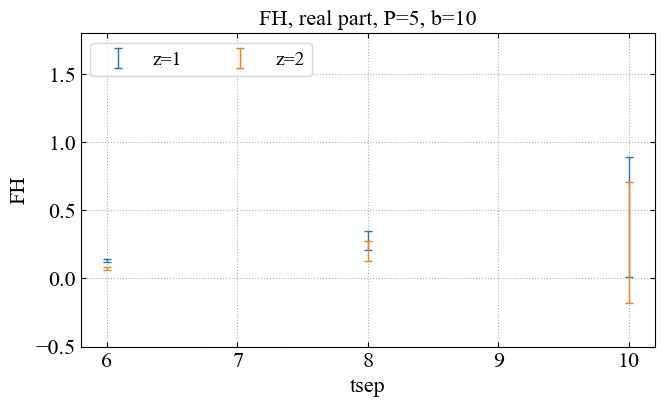

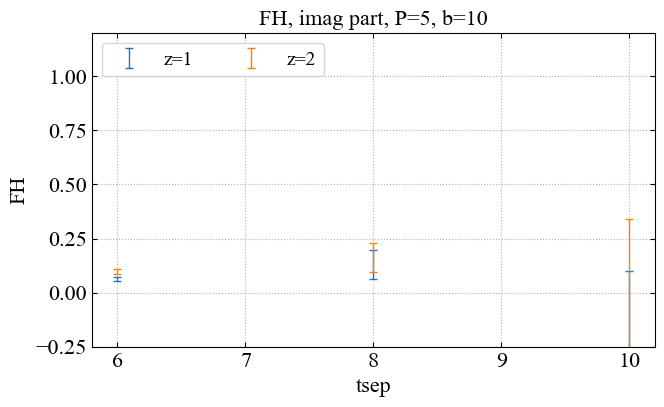

In [7]:
px = py = 5
pz = 0
b = 10
tau_cut_plot = 3

# * fh real part
fig, ax = default_plot()
for z in range(1,3):
    fh_real, fh_imag = get_fh_data(px, py, pz, b, z, tsep_ls, jk_bs="bs", tau_cut=tau_cut_plot)
    fh_real_avg = gv.dataset.avg_data(fh_real, bstrap=True)
    ax.errorbar(tsep_ls[:-1], gv.mean(fh_real_avg), yerr=gv.sdev(fh_real_avg), label=f"z={z}", **errorb)
ax.legend(loc="upper left", ncol=3, **fs_small_p)
ax.set_title(f"FH, real part, P={px}, b={b}", **fs_p)
ax.set_xlabel("tsep", **fs_p)
ax.set_ylabel("FH", **fs_p)
ax.set_ylim(-0.5, 1.8)
plt.tight_layout()
plt.show()

# * fh imag part
fig, ax = default_plot()
for z in range(1,3):
    fh_real, fh_imag = get_fh_data(px, py, pz, b, z, tsep_ls, jk_bs="bs", tau_cut=tau_cut_plot)
    fh_imag_avg = gv.dataset.avg_data(fh_imag, bstrap=True)
    ax.errorbar(tsep_ls[:-1], gv.mean(fh_imag_avg), yerr=gv.sdev(fh_imag_avg), label=f"z={z}", **errorb)
ax.legend(loc="upper left", ncol=3, **fs_small_p)
ax.set_title(f"FH, imag part, P={px}, b={b}", **fs_p)
ax.set_xlabel("tsep", **fs_p)
ax.set_ylabel("FH", **fs_p)
ax.set_ylim(-0.25, 1.2)
plt.tight_layout()
plt.show()

